# **Segmentación de clientes (clustering)**



En este notebook desarrollaremos el modelo de clasificación de clientes que queremos llevar acabo. Despues de hacer una breve investigación al respecto, hemos decidido decantarnos por **Kmeans**. Con los siguientes objetivos.

- Identificar cuales son auqellas variables que más peso tienen sobre los clientes.
- Identificar todas aquellas similitudes que puedan crear un clustring entre los clientes existentes.
- Iterar diferentes parámetros que nos permitan sacar el mejor resultado.



In [1]:
#conectamos el drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Librerías

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

In [ ]:

# reduces the memory of a dataframe
def reduce_mem_usage(df, verbose = True):
    
    '''
    Reduces the space that a DataFrame occupies in memory.

    This function iterates over all columns in a df and downcasts them to lower type to save memory.
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
              .format(end_mem, 100 * (start_mem - end_mem) / start_mem))

## Lectura de datos (CSV con resultados de análisis)

In [ ]:
ruta = "/content/drive/MyDrive/clases Data/TFM/"
clientes = pd.read_csv(ruta +'analisis_joined.csv')

## Revisión General

In [ ]:
del(clientes['Unnamed: 0'])
clientes

,pk_cid,pk_partition,Period,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,Year,Month,Total_productos,Total_productos_mes_anterior,Diference,country_id,region_code,gender,age,deceased,salary,entry_date,entry_channel,active_customer,segment,Total_account_10,Total_funding_40,Total_loans_60,Profit
0,1000028,2018-01-28,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018,1,2,NaN,NaN,ES,28.0,H,43,N,133378.89,2017-01-03,KHC,1.0,02 - PARTICULARES,1,0,1,70
1,1000028,2018-02-28,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018,2,2,2.0,0.0,ES,28.0,H,43,N,133378.89,2017-01-03,KHC,1.0,02 - PARTICULARES,1,0,1,70
2,1000028,2018-03-28,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018,3,2,2.0,0.0,ES,28.0,H,43,N,133378.89,2017-01-03,KHC,1.0,02 - PARTICULARES,1,0,1,70
3,1000028,2018-04-28,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018,4,2,2.0,0.0,ES,28.0,H,43,N,133378.89,2017-01-03,KHC,1.0,02 - PARTICULARES,1,0,1,70
4,1000028,2018-05-28,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,2018,5,2,2.0,0.0,ES,28.0,H,43,N,133378.89,2017-01-03,KHC,1.0,02 - PARTICULARES,1,0,1,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5962919,999892,2019-01-28,13,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,2019,1,4,4.0,0.0,ES,28.0,H,37,N,335128.68,2017-03-27,KFA,1.0,01 - TOP,3,0,1,90
5962920,999892,2019-02-28,14,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,2019,2,4,4.0,0.0,ES,28.0,H,37,N,335128.68,2017-03-27,KFA,1.0,01 - TOP,3,0,1,90
5962921,999892,2019-03-28,15,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,2019,3,4,4.0,0.0,ES,28.0,H,38,N,335128.68,2017-03-27,KFA,1.0,01 - TOP,3,0,1,90
5962922,999892,2019-04-28,16,0,0,0,0,0,0,0,0,0,0,1,1,1,0,1,2019,4,4,4.0,0.0,ES,28.0,H,38,N,335128.68,2017-03-27,KFA,1.0,01 - TOP,3,0,1,90


In [ ]:
reduce_mem_usage(clientes, verbose=True)

Mem. usage decreased to 557.30 Mb (66.9% reduction)


In [ ]:
#En esta ocasión, utilizaremos solo la columna de productos totales (de esta manera, podemos quitarnos 15 columnas y tener mas visibilidad de las variables)
variables_clientes = clientes.drop(["short_term_deposit", "loans", "mortgage", "mortgage", "securities", "long_term_deposit", "em_account_pp", "credit_card", "payroll", 
               "payroll_account", "emc_account", "debit_card", "em_account_p", "em_acount", "Total_productos_mes_anterior", "Diference", "region_code",
               "deceased", "active_customer", "Total_account_10", "Total_funding_40", "Total_loans_60", "funds", "salary", "pension_plan", "entry_channel", 
               "segment", "entry_date", "Period", "Year", "Month", "pk_partition"], axis=1)
variables_clientes

,pk_cid,Total_productos,country_id,gender,age,Profit
0,1000028,2,ES,H,43,70
1,1000028,2,ES,H,43,70
2,1000028,2,ES,H,43,70
3,1000028,2,ES,H,43,70
4,1000028,2,ES,H,43,70
...,...,...,...,...,...,...
5962919,999892,4,ES,H,37,90
5962920,999892,4,ES,H,37,90
5962921,999892,4,ES,H,38,90
5962922,999892,4,ES,H,38,90


In [ ]:
#Antes de hacer cualquier cosa, necesitamos dejar el número del cliente como registro único y eliminar todas las particiones en las que se encuentra repetido.
#Importante que debemos dejar el último, ya que es el que contiene tanto el total de productos finales, como el profir que le aporta a la empresa.
variables_clientes = variables_clientes.drop_duplicates(["pk_cid"], keep='last').reset_index()
variables_clientes

,index,pk_cid,Total_productos,country_id,gender,age,Profit
0,16,1000028,2,ES,H,44,70
1,33,1000096,0,ES,H,10,0
2,42,1000105,0,ES,V,47,0
3,56,1000113,0,ES,V,54,0
4,67,1000130,0,ES,H,44,0
...,...,...,...,...,...,...,...
456368,5962866,998859,6,ES,V,44,190
456369,5962872,999706,0,ES,H,14,0
456370,5962889,999825,1,ES,V,40,10
456371,5962906,999835,1,ES,H,32,40


In [ ]:
variables_clientes.drop(variables_clientes.columns[0], inplace=True, axis=1) #también quitaremos el id del cliente ya que para el clustering no es relevante.
#Ahora veamos si hay alguna columna donde nos falte información, y que tipo de dato es.
print("Database has {} obserwations (customers) and {} columns (attributes).".format(variables_clientes.shape[0],variables_clientes.shape[1]))
print("Missing values in each column:\n{}".format(variables_clientes.isnull().sum()))
print("Columns data types:\n{}".format(variables_clientes.dtypes))

Database has 456373 obserwations (customers) and 6 columns (attributes).
Missing values in each column:
pk_cid             0
Total_productos    0
country_id         0
gender             2
age                0
Profit             0
dtype: int64
Columns data types:
pk_cid              int32
Total_productos      int8
country_id         object
gender             object
age                  int8
Profit              int16
dtype: object


In [ ]:
n_unique = variables_clientes.nunique() #Veamos el total de valores únicos por columna
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
pk_cid             456373
Total_productos        10
country_id             41
gender                  2
age                   104
Profit                 30
dtype: int64


In [ ]:
variables_clientes.describe()

,pk_cid,Total_productos,age,Profit
count,4.563730e+05,456373.000000,456373.000000,456373.000000
mean,1.274945e+06,0.962390,30.573971,16.674277
std,1.790008e+05,0.903939,12.335248,28.038326
min,1.589100e+04,0.000000,2.000000,0.000000
25%,1.143728e+06,0.000000,22.000000,0.000000
50%,1.284769e+06,1.000000,25.000000,10.000000
75%,1.423470e+06,1.000000,36.000000,10.000000
max,1.553689e+06,9.000000,105.000000,310.000000


En esta tabla tenemos probablemente los datos mas importantes de nuestra base de datos. 


*   De media el cliente tiene 1 producto contratado.
*   El máximo de productos contratados por cliente son 9.
*   El promedio de edad en nuestros clientes es de 30 años.
*   Tenemos un error en las edades, ya que hay clientes con edades de 2 años (y no sabemos si el de 105 sea real).
*   De media, tenemos un beneficio por cliente de 16.67€
*   El max. por cliente es de 310€.







## Análisis de Nulos

In [ ]:
variables_clientes.isnull().value_counts()

pk_cid  Total_productos  country_id  gender  age    Profit
False   False            False       False   False  False     456371
                                     True    False  False          2
dtype: int64

In [ ]:
variables_clientes = variables_clientes.dropna(inplace=False) #Eliminamos los 2 registros con NA´s

## Dataframe Variables clientes

Hemos dejado el dataframe listo para hacer clustering de clientes. Dejando solo las variables tanto categóricas como numéricas que nos puedan ayudar a segmentar a los clientes.

In [ ]:
variables_clientes

,pk_cid,Total_productos,country_id,gender,age,Profit
0,1000028,2,ES,H,44,70
1,1000096,0,ES,H,10,0
2,1000105,0,ES,V,47,0
3,1000113,0,ES,V,54,0
4,1000130,0,ES,H,44,0
...,...,...,...,...,...,...
456368,998859,6,ES,V,44,190
456369,999706,0,ES,H,14,0
456370,999825,1,ES,V,40,10
456371,999835,1,ES,H,32,40


In [ ]:
reduce_mem_usage(variables_clientes, verbose=True)

Mem. usage decreased to 13.93 Mb (0.0% reduction)


In [ ]:
variables_clientes.to_csv('variables_clientes.csv')#Guardamos el CSV para seguir desde aqui con el dataset final

## Gráficas de variables categóricas y numéricas

In [ ]:
variables_clientes = pd.read_csv('variables_clientes.csv')

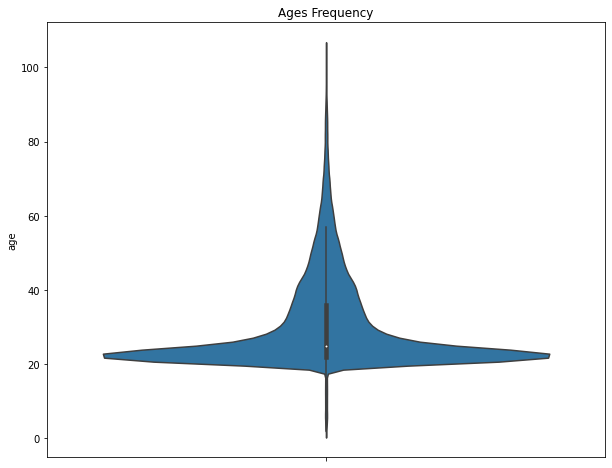

In [ ]:
# A continuación plotearemos la frecuencia de las edades para ver la distribución.
plt.figure(figsize=(10,8))
plt.title("Ages Frequency")
sns.axes_style("dark")
sns.violinplot(y=variables_clientes["age"])
plt.show()

Podemos ver una clarísima concentración de clientes en edades entre 20 y 40 años. claramente un grupo debería ir enfocado a ese rango.


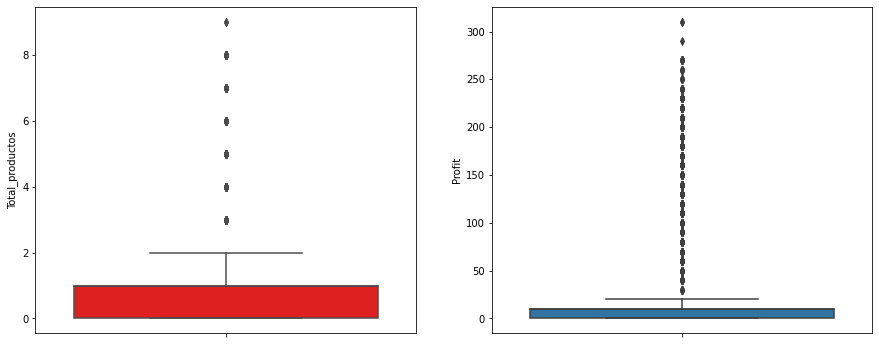

In [ ]:
#A continuación lo que haremos es una box para visualizar mejor los rangos de distribución tanto en los productos totales que contrata un cliente, como el profit que nos aporta.
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(y=variables_clientes["Total_productos"], color="red")
plt.subplot(1,2,2)
sns.boxplot(y=variables_clientes["Profit"])
plt.show()

Claramente la mayoría de los clientes solo tienen contratados 1 producto de 15, mientras que la gran mayoría tambien se concentra entre el 0 y el 30 de profit.

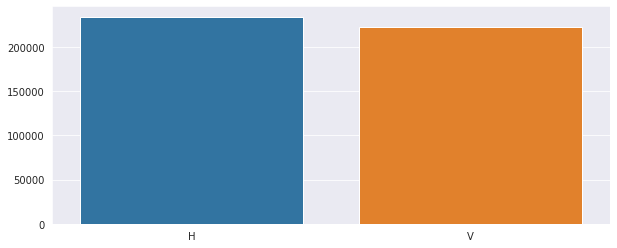

In [ ]:
#Ahora es turno del género. Haremos una gráfica de barras para visualizar mejor las cantidades de clientes hombres y muejeres (Hembras y Varones en el gráfico)
genders = variables_clientes.gender.value_counts()
sns.set_style("darkgrid")
plt.figure(figsize=(10,4))
sns.barplot(x=genders.index, y=genders.values)
plt.show()

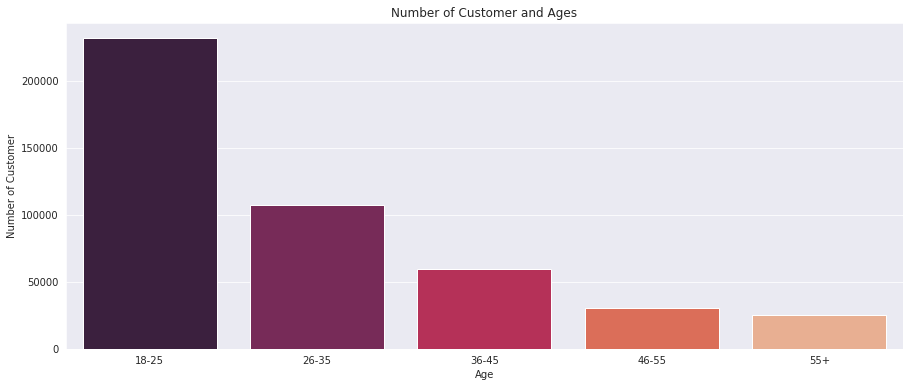

In [ ]:
#Crearemos 5 grupos de edades para ver la ditribución de clientes en cada grupo.

age18_25 = variables_clientes.age[(variables_clientes.age <= 25) & (variables_clientes.age >= 18)]
age26_35 = variables_clientes.age[(variables_clientes.age <= 35) & (variables_clientes.age >= 26)]
age36_45 = variables_clientes.age[(variables_clientes.age <= 45) & (variables_clientes.age >= 36)]
age46_55 = variables_clientes.age[(variables_clientes.age <= 55) & (variables_clientes.age >= 46)]
age55above = variables_clientes.age[variables_clientes.age >= 56]

x = ["18-25","26-35","36-45","46-55","55+"]
y = [len(age18_25.values),len(age26_35.values),len(age36_45.values),len(age46_55.values),len(age55above.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=x, y=y, palette="rocket")
plt.title("Number of Customer and Ages")
plt.xlabel("Age")
plt.ylabel("Number of Customer")
plt.show()

Tenemos claramente un ganador. Sabiamos por la gráfica de violín que la gran mayoría de nuestros clientes se concentran entre los 18-25 años, el siguiente grupo es tambien muy jóven entre 26-35. Esto nos ayudará a tomar decisiones en nuestra estrategia de MKT.

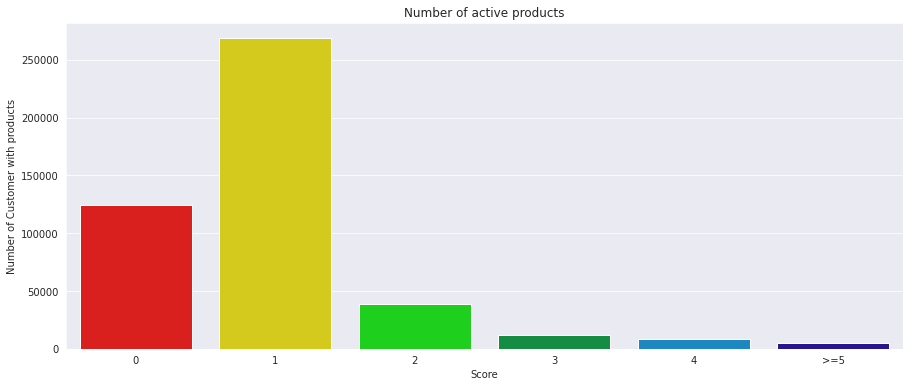

In [ ]:
# A continación haremos 5 grupos para los clientes que tienen contratados cierto número de productos.
ss_0 = variables_clientes["Total_productos"][(variables_clientes["Total_productos"] == 0)]
ss_1 = variables_clientes["Total_productos"][(variables_clientes["Total_productos"] == 1)]
ss_2 = variables_clientes["Total_productos"][(variables_clientes["Total_productos"] == 2)]
ss_3 = variables_clientes["Total_productos"][(variables_clientes["Total_productos"] == 3)]
ss_4 = variables_clientes["Total_productos"][(variables_clientes["Total_productos"] == 4)]
ss_5 = variables_clientes["Total_productos"][(variables_clientes["Total_productos"] >= 5)]

ssx = ["0", "1", "2", "3", "4", ">=5"]
ssy = [len(ss_0.values), len(ss_1.values), len(ss_2.values), len(ss_3.values), len(ss_4.values), len(ss_5.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=ssx, y=ssy, palette="nipy_spectral_r")
plt.title("Numero de Productos Contratados")
plt.xlabel("Score")
plt.ylabel("Numero de clientes con productos")
plt.show()

Tenemos sobre 120k clientes registrados que no tienen contratado ningún producto, y con 1 (casi todos la cuenta EM)tenemos otros 260k. Como ya lo habíamos comentado, sería interesante enfocar nuestra campaña de MKT a este grupo de clientes que que tienen entre 0-1 productos.

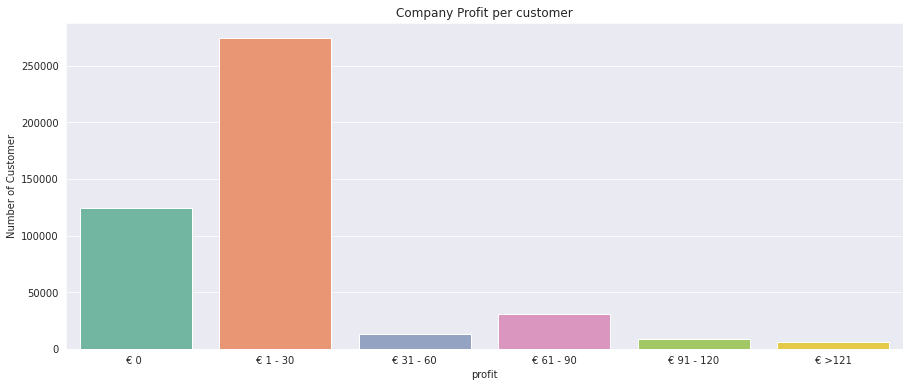

In [ ]:

ai0 = variables_clientes["Profit"][(variables_clientes["Profit"] == 0)]
ai0_30 = variables_clientes["Profit"][(variables_clientes["Profit"] > 0) & (variables_clientes["Profit"] <= 30)]
ai31_60 = variables_clientes["Profit"][(variables_clientes["Profit"] >= 31) & (variables_clientes["Profit"] <= 60)]
ai61_90 = variables_clientes["Profit"][(variables_clientes["Profit"] >= 61) & (variables_clientes["Profit"] <= 90)]
ai91_120 = variables_clientes["Profit"][(variables_clientes["Profit"] >= 91) & (variables_clientes["Profit"] <= 120)]
ai121 = variables_clientes["Profit"][(variables_clientes["Profit"] >= 121)]

aix = ["€ 0 ", "€ 1 - 30", "€ 31 - 60", "€ 61 - 90", "€ 91 - 120", "€ >121"]
aiy = [len(ai0.values), len(ai0_30.values), len(ai31_60.values), len(ai61_90.values), len(ai91_120.values), len(ai121.values)]

plt.figure(figsize=(15,6))
sns.barplot(x=aix, y=aiy, palette="Set2")
plt.title("Company Profit per customer")
plt.xlabel("profit")
plt.ylabel("Number of Customer")
plt.show()

Tenemos mas de 100k clientes que no nos generan ningun beneficio, y la gran mayoría (sobre 260k, que corresponden a mas del 50%) solo nos generan ingresos de 1-30 euros. Como ya vimos anteriormente, la media de ingreso por cliente esta sobre los €16.

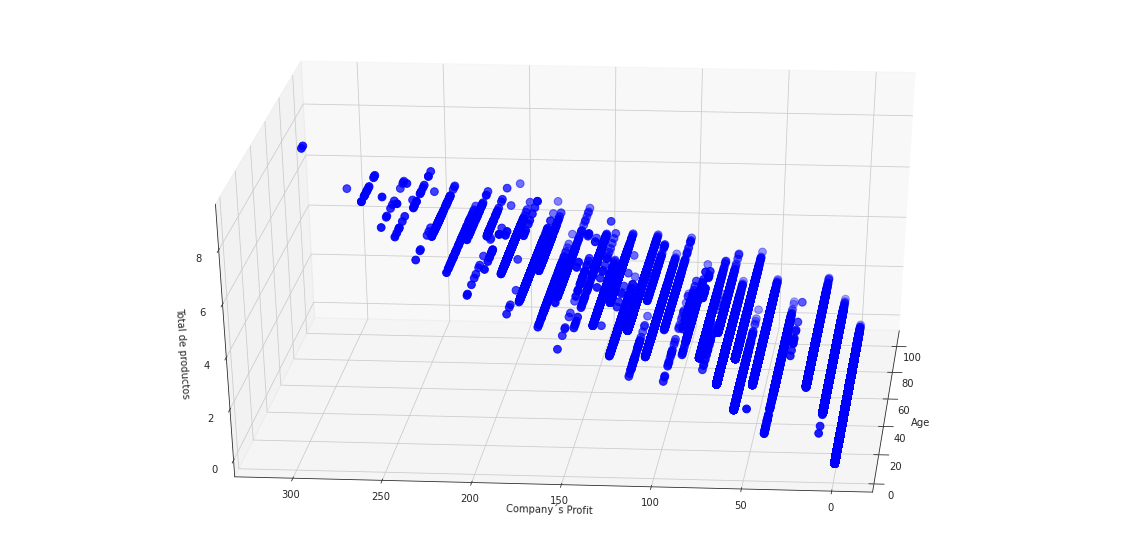

In [ ]:
#A continuación, plotearemos en 3 dimensiones las 3 últimas variables.
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(variables_clientes.age, variables_clientes["Profit"], variables_clientes["Total_productos"], c='blue', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Company´s Profit")
ax.set_zlabel('Total de productos')
plt.show()

# Modelo de segmentacion Kmeans Clustering

In [18]:
variables_clientes = pd.read_csv('variables_clientes.csv')

In [20]:
#Vamos a seleccionar las columnas para el clustering con Kmeans
selected_cols = ["age","Total_productos", "Profit"]
cluster_data = variables_clientes.loc[:,selected_cols]

In [ ]:
def distributions(df):#veamos la distribucion de las variables en formato lineal de barras.
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["age"], ax=ax1)
    sns.distplot(df["Total_productos"], ax=ax2)
    sns.distplot(df["Profit"], ax=ax3)
    plt.tight_layout()

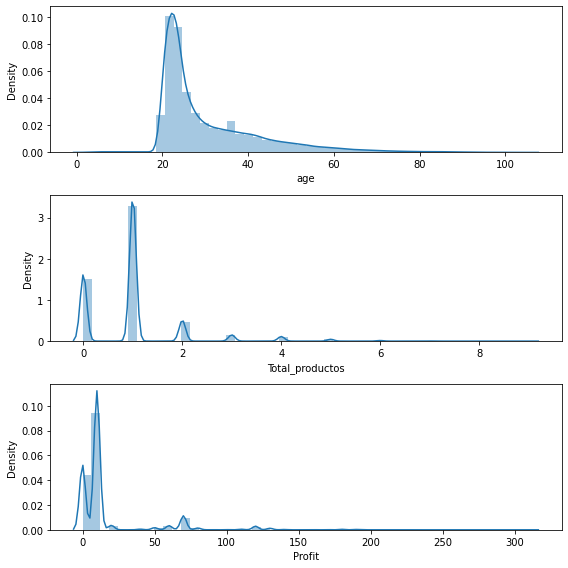

In [ ]:
distributions(cluster_data)


Podemos ver que la concentración de clientes en ciertas zonas de nuestros rangos es bastante marcada. Intentaremos Homologar las escalas para tener una mejor agrupación de clientes

In [21]:
cluster_data

,age,Total_productos,Profit
0,44,2,70
1,10,0,0
2,47,0,0
3,54,0,0
4,44,0,0
...,...,...,...
456366,44,6,190
456367,14,0,0
456368,40,1,10
456369,32,1,40


In [22]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_data)

In [8]:
cluster_scaled

array([[ 1.08846757,  1.14787822,  1.90189601],
       [-1.66792479, -1.06466034, -0.59469399],
       [ 1.33167866, -1.06466034, -0.59469399],
       ...,
       [ 0.76418611,  0.04160894, -0.23803827],
       [ 0.11562321,  0.04160894,  0.83192887],
       [ 0.60204539,  3.36041678,  2.61520744]])

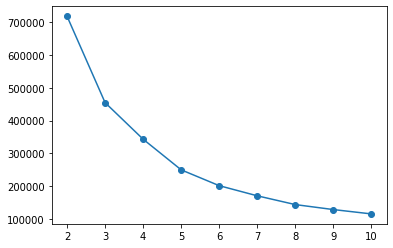

In [9]:
clusters_range = [2,3,4,5,6,7,8,9,10]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')
#Con este método del codo veremos cual es el número idoneo de clusters para nuestros clientes

In [26]:
 #kmeans = KMeans(n_clusters=5, random_state=0).fit(cluster_scaled)

In [27]:
#i_kmeans = kmeans.predict(cluster_scaled)
#i_kmeans

In [28]:
#cluster_inverse = scaler.inverse_transform(cluster_scaled)
#cluster_inverse

In [23]:
kmeans_sel = KMeans(n_clusters=5, random_state=0).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

In [25]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)
grouped_km

,age,Total_productos,Profit
Cluster,,,
0,25.9,0.0,0.0
1,37.3,2.2,68.0
2,25.0,1.0,10.3
3,40.0,4.3,133.2
4,53.2,0.7,8.1


Nos hemos decantado por estos 5 grupos de clientes:



* 1. Gente muy joven, con 0 productos contratados, y por lo tanto 0 beneficios.
* 2. Gente menos jóven, con numero optimo de productos, y beneficio medio.
* 3. Los + jovenes, con pocos producto, y un bajo beneficio.
* 4. Gente madura, muchos productos, el mejor beneficio. (target)
* 5. Los + Maduros, muy pocos productos, muy poco beneficio (el mas bajo).








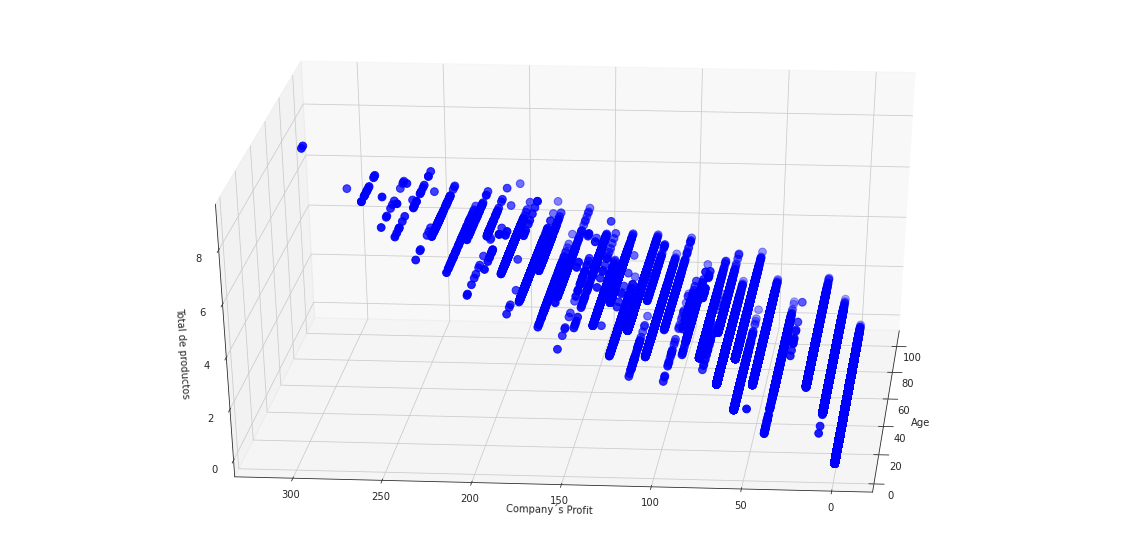

In [29]:
sns.set_style("white")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(clustered_data.age, clustered_data["Profit"], clustered_data["Total_productos"], c='blue', s=60)
ax.view_init(30, 185)
plt.xlabel("Age")
plt.ylabel("Company´s Profit")
ax.set_zlabel('Total de productos')
plt.show()